# **Análisis de las señales sEMG**
---

En este notebook se presentan los resultados obtenidos a partir de las señales de electromiografía de superficie (sEMG) registradas en los músculos bíceps y tríceps braquial. El análisis se estructura en las siguientes partes fundamentales:

1.  **Configuración del Entorno y Funciones:** Se importan las librerías, se definen las rutas a los archivos de datos y se encapsula la lógica de procesamiento en funciones reutilizables.
2.  **Metodología de Procesamiento:** Se detalla el pipeline de procesamiento aplicado a las señales crudas para obtener una representación cuantificable de la actividad muscular, justificando cada paso con base en la literatura estándar.
3.  **Análisis en el Dominio del Tiempo:** Se visualiza e interpreta la actividad muscular (envolvente RMS) para cada uno de los ensayos realizados, comparando los diferentes niveles de activación.
4.  **Análisis en el Dominio de la Frecuencia:** Se examina el contenido espectral de las señales durante contracciones máximas para verificar sus características fisiológicas.

## **1. Inicio:**
---
En esta primera parte, configuramos el entorno, declaramos variables, definimos las rutas de las señales y definimos las funciones que usaremos para el análisis de las señales

### Configuración del entorno:
- Se importan las librerías necesarias
- Se configuran las rutas de los archivos analizar
- Se definen las constantes del kit BITalino

In [1]:
# Como primer paso, importamos las librería que vamos a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
import os

In [2]:
# Configuramos las rutas y los archivos de interés para el análisis
ruta_base = '../Señales adquiridas en el laboratorio/'

archivos_a_analizar = {
    'biceps_lento': ruta_base + 'reposo1_106050.txt',
    'biceps_maximo': ruta_base + 'contraccion1.txt',
    'triceps_lento': ruta_base + 'reposo_tricep_1-09-03_12-55-52.txt',
    'triceps_maximo': ruta_base + 'tricep_contraccion-09-03_12-57-54.txt'
}

# Archivo de referencia para el tono muscular (usaremos una sección de este)
ruta_reposo_biceps = ruta_base + 'reposo1_106050.txt'

In [ ]:
# Parámetros del Sensor BITalino (según manual)
fs = 1000      # Frecuencia de muestreo (Hz)
n_bits = 10    # Resolución del ADC (bits)
vcc = 3.3      # Voltaje de operación (V)
g_emg = 1009   # Ganancia del sensor EMG

### Definición de las funciones que empleamos para los análisis:
- Función de carga de datos
- Función de conversión de valores ADC a milivolts (mV)
- Función para aplicar un filtro pasa banda
- Función para calcular la envolvente RMS de una señal
- Función para detectar inicio y fin de contracciones (enventanarlas)

In [4]:
def cargar_senal_adc(ruta_archivo):
    """Carga la señal cruda (valores ADC) desde un archivo .txt de OpenSignals."""
    try:
        data_df = pd.read_csv(ruta_archivo, comment='#', delim_whitespace=True, header=None)
        return data_df.iloc[:, -1].values
    except FileNotFoundError:
        print(f"ERROR: No se encontró el archivo en la ruta '{ruta_archivo}'")
        return None

def adc_to_mv(senal_adc, n=10, vcc=3.3, g_emg=1009):
    """Convierte la señal de valores ADC a milivoltios (mV) según la fórmula de BITalino."""
    senal_mv = (((senal_adc / (2**n)) - 0.5) * vcc) / g_emg * 1000
    return senal_mv

def filtrar_emg(senal_mv, fs=1000):
    """Aplica un filtro pasa-banda a la señal en mV."""
    low_cut, high_cut = 20, 450
    nyq = 0.5 * fs
    b, a = butter(4, [low_cut/nyq, high_cut/nyq], btype='band')
    senal_filtrada = filtfilt(b, a, senal_mv)
    return senal_filtrada

def calcular_rms(senal_rectificada, fs=1000):
    """Calcula la envolvente RMS de una señal rectificada."""
    win_size = int(0.15 * fs) # Ventana de 150 ms
    rms_envelope = np.sqrt(np.convolve(np.power(senal_rectificada, 2), np.ones(win_size)/win_size, mode='valid'))
    return rms_envelope

def detectar_eventos(rms_signal, fs=1000, reposo_duracion_s=5):
    """Detecta inicios y finales de contracciones basados en un umbral."""
    muestras_reposo = int(reposo_duracion_s * fs)
    if len(rms_signal) < muestras_reposo:
        muestras_reposo = len(rms_signal)
        
    reposo_segmento = rms_signal[:muestras_reposo]
    umbral = np.mean(reposo_segmento) + 3 * np.std(reposo_segmento)
    
    activacion = (rms_signal > umbral).astype(int)
    diff_activacion = np.diff(activacion, prepend=0)
    
    inicios = np.where(diff_activacion == 1)[0]
    finales = np.where(diff_activacion == -1)[0]
    
    if len(inicios) > len(finales):
        finales = np.append(finales, len(rms_signal) - 1)
        
    eventos = [(start, end) for start, end in zip(inicios, finales) if end > start]
    return eventos, umbral

## **2. Metodología de Procesamiento de la Señal**
---

El primer paso del análisis consiste en transformar los datos crudos del sensor a unidades físicas con significado fisiológico y eliminar el ruido que enmascara la actividad muscular.

### 2.1 Conversión de ADC a Milivoltios (mV)

La señal adquirida por el kit BITalino se entrega como una serie de valores de un Conversor Análogo-Digital (ADC), que son unidades arbitrarias. Para poder comparar estos valores con la literatura científica y entender su magnitud real, es indispensable convertirlos a milivoltios (mV). Según el manual del fabricante (BITalino, 2020) [4], se utilizan las siguientes ecuaciones:

$E_{MG}(V) = \frac{(\frac{ADC}{2^n} - \frac{1}{2}) \times VCC}{G_{EMG}}$  *(Ecuación 1)*

$E_{MG}(mV) = E_{MG}(V) \times 1000$  *(Ecuación 2)*

Donde:
- **ADC:** El valor crudo de la muestra.
- **n:** La resolución del ADC (10 bits para este dispositivo).
- **VCC:** El voltaje de operación (3.3 V).
- **G_EMG:** La ganancia del sensor de EMG (1009).

### 2.2 Filtrado Pasa-Banda

Una vez en milivoltios, la señal aún contiene componentes no deseados. La señal sEMG fisiológicamente útil se encuentra en un rango de frecuencia específico. Para aislarla, se aplica un **filtro pasa-banda** (Konrad, 2005) [5]. Este filtro elimina:

1.  **Ruido de baja frecuencia (< 20 Hz):** Principalmente artefactos de movimiento, que causan una ondulación o deriva en la línea base de la señal, especialmente visible en periodos de reposo.
2.  **Ruido de alta frecuencia (> 450 Hz):** Ruido electrónico ambiental que no forma parte de la señal biológica.

La siguiente figura ilustra el efecto de este filtrado en un segmento que transiciona del reposo a una contracción lenta del bíceps. Se puede observar claramente cómo el filtro estabiliza la línea base.

C:\Users\Alvaro\AppData\Local\Temp\ipykernel_4024\2582466692.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data_df = pd.read_csv(ruta_archivo, comment='#', delim_whitespace=True, header=None)


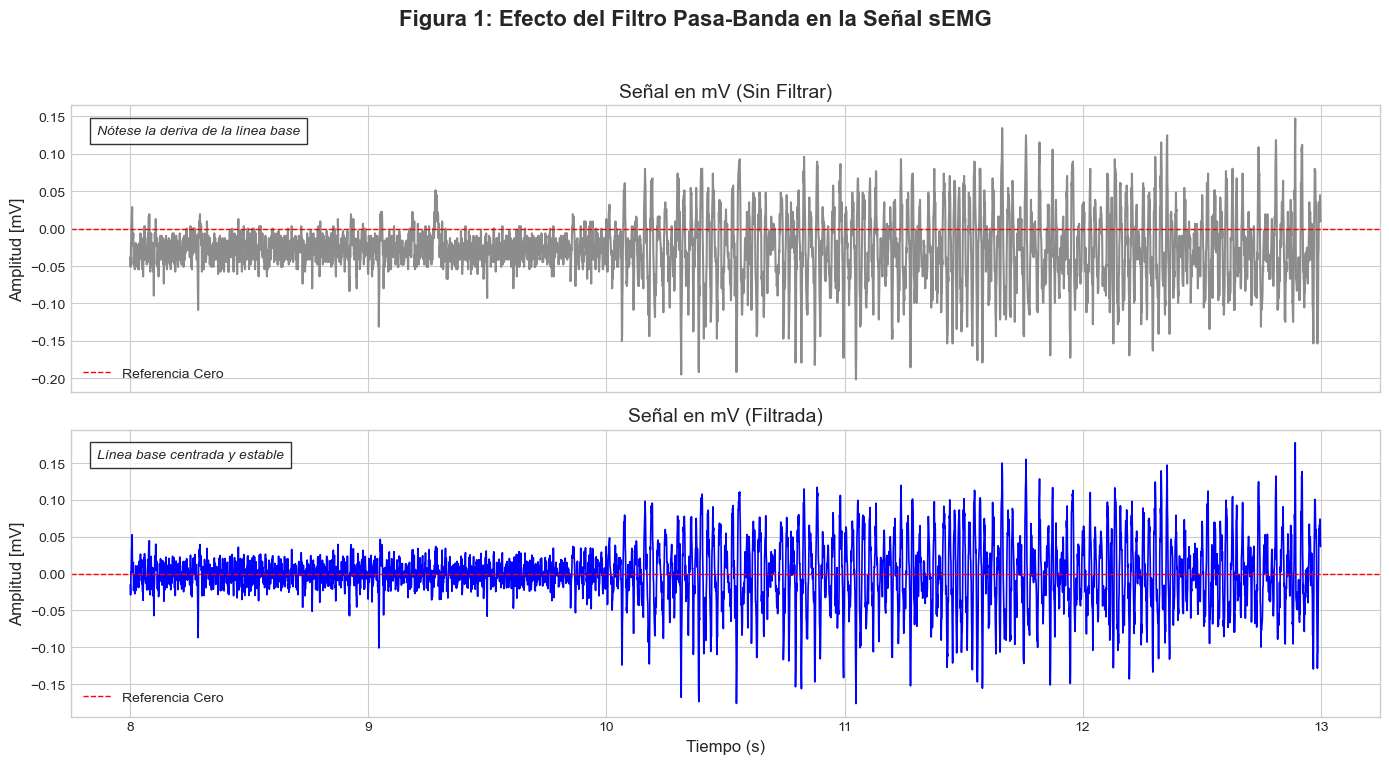

In [26]:
# Cargar la señal de contracción lenta del bíceps, que tiene transiciones claras
adc_signal = cargar_senal_adc(archivos_a_analizar['biceps_lento'])
if adc_signal is not None:
    # 1. Convertir a mV
    mv_signal_unfiltered = adc_to_mv(adc_signal)
    
    # 2. Filtrar
    mv_signal_filtered = filtrar_emg(mv_signal_unfiltered, fs)
    
    # Crear un vector de tiempo para un segmento que incluya reposo y contracción
    start_time_s = 8
    end_time_s = 13
    start_sample = int(start_time_s * fs)
    end_sample = int(end_time_s * fs)
    
    t_segment = np.arange(len(mv_signal_unfiltered))[start_sample:end_sample] / fs
    
    # Graficar la comparación
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    # Subplot para la señal sin filtrar
    ax1.plot(t_segment, mv_signal_unfiltered[start_sample:end_sample], color='gray', alpha=0.9)
    ax1.axhline(0, color='red', linestyle='--', linewidth=1, label='Referencia Cero') # <-- LÍNEA AÑADIDA
    ax1.set_title('Señal en mV (Sin Filtrar)', fontsize=14)
    ax1.set_ylabel('Amplitud [mV]', fontsize=12)
    ax1.grid(True)
    ax1.text(0.02, 0.9, 'Nótese la deriva de la línea base', 
             transform=ax1.transAxes, style='italic', bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
    ax1.legend()

    # Subplot para la señal filtrada
    ax2.plot(t_segment, mv_signal_filtered[start_sample:end_sample], color='blue', linewidth=1.2)
    ax2.axhline(0, color='red', linestyle='--', linewidth=1, label='Referencia Cero') # <-- LÍNEA AÑADIDA
    ax2.set_title('Señal en mV (Filtrada)', fontsize=14)
    ax2.set_ylabel('Amplitud [mV]', fontsize=12)
    ax2.set_xlabel('Tiempo (s)', fontsize=12)
    ax2.grid(True)
    ax2.text(0.02, 0.9, 'Línea base centrada y estable', 
             transform=ax2.transAxes, style='italic', bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
    ax2.legend()

    fig.suptitle('Figura 1: Efecto del Filtro Pasa-Banda en la Señal sEMG', fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### 2.3 Tono Muscular y Cuantificación de la Activación (RMS)

Incluso en un estado de aparente reposo, un músculo esquelético mantiene una ligera contracción residual conocida como **tono muscular**. Esta actividad es crucial para mantener la postura y la preparación para el movimiento. En la señal sEMG, el tono muscular se manifiesta como una actividad eléctrica de baja amplitud y fluctuante, que representa la activación asincrónica de unas pocas unidades motoras [6]. Es importante distinguir este fenómeno fisiológico del ruido electrónico.

La señal sEMG filtrada (Figura 1, abajo) es una señal oscilante con un promedio cercano a cero, lo que dificulta la cuantificación directa de su "intensidad". Para obtener una medida representativa de la activación muscular, se calcula su envolvente. El método estándar es el **Valor Cuadrático Medio (RMS)**, calculado sobre ventanas de tiempo móviles. El RMS proporciona una medida de la potencia de la señal y se ha demostrado que tiene una correlación más consistente con el nivel de fuerza muscular que otras técnicas [7].

La siguiente figura muestra un segmento de la señal filtrada en reposo, ilustrando el tono muscular, y la correspondiente señal RMS que se usará para el resto del análisis.

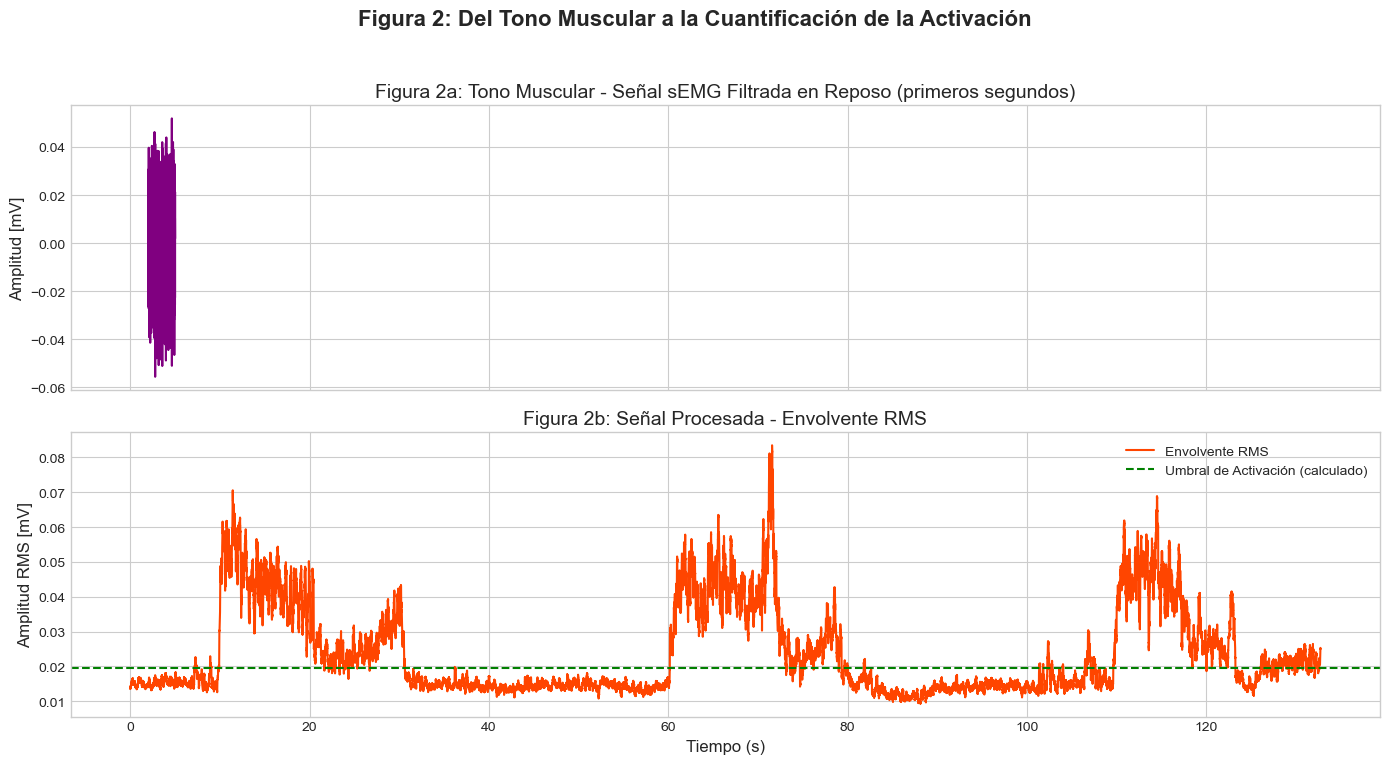

In [28]:
# Usaremos la misma señal filtrada de la celda anterior
if 'mv_signal_filtered' in locals():
    
    # Seleccionar solo la porción de reposo para ilustrar el tono muscular
    start_reposo_s = 2
    end_reposo_s = 5
    start_sample_r = int(start_reposo_s * fs)
    end_sample_r = int(end_reposo_s * fs)
    
    t_reposo_segment = np.arange(start_sample_r, end_sample_r) / fs
    reposo_segment_filtered = mv_signal_filtered[start_sample_r:end_sample_r]
    
    # Calcular la envolvente RMS para todo el archivo para mostrarla debajo
    rms_signal_completa = calcular_rms(np.abs(mv_signal_filtered), fs)
    t_rms_completo = np.arange(len(rms_signal_completa)) / fs
    
    # Graficar
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    # Subplot para el Tono Muscular (señal filtrada)
    ax1.plot(t_reposo_segment, reposo_segment_filtered, color='purple')
    ax1.set_title('Figura 2a: Tono Muscular - Señal sEMG Filtrada en Reposo (primeros segundos)', fontsize=14)
    ax1.set_ylabel('Amplitud [mV]', fontsize=12)
    ax1.grid(True)
    
    # Subplot para la Envolvente RMS
    ax2.plot(t_rms_completo, rms_signal_completa, color='orangered', label='Envolvente RMS')
    ax2.set_title('Figura 2b: Señal Procesada - Envolvente RMS', fontsize=14)
    ax2.set_xlabel('Tiempo (s)', fontsize=12)
    ax2.set_ylabel('Amplitud RMS [mV]', fontsize=12)
    ax2.grid(True)
    
    # Mostrar el umbral de detección que usaremos más adelante
    _, umbral = detectar_eventos(rms_signal_completa, fs, reposo_duracion_s=8)
    ax2.axhline(umbral, color='green', linestyle='--', linewidth=1.5, label=f'Umbral de Activación (calculado)')
    ax2.legend()
    
    fig.suptitle('Figura 2: Del Tono Muscular a la Cuantificación de la Activación', fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## 3. Análisis en el Dominio del Tiempo
---

Una vez establecida la metodología de procesamiento, se procede a analizar la actividad muscular durante los ensayos completos. Se utiliza un algoritmo de detección de eventos para identificar objetivamente los periodos de contracción, definidos como los segmentos donde la señal RMS supera un umbral estadístico **(media + 3*DE de la actividad en reposo inicial)** [8]. Estos periodos se marcan con áreas sombreadas en las siguientes gráficas.

### 3.1 Análisis del Músculo Bíceps Braquial

Se comparó la activación del bíceps bajo dos condiciones: contracciones lentas sin oposición y contracciones voluntarias máximas (CVM) con oposición.

Procesando todas las señales para el análisis en el dominio del tiempo...


C:\Users\Alvaro\AppData\Local\Temp\ipykernel_4024\2582466692.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data_df = pd.read_csv(ruta_archivo, comment='#', delim_whitespace=True, header=None)
C:\Users\Alvaro\AppData\Local\Temp\ipykernel_4024\2582466692.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data_df = pd.read_csv(ruta_archivo, comment='#', delim_whitespace=True, header=None)
C:\Users\Alvaro\AppData\Local\Temp\ipykernel_4024\2582466692.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data_df = pd.read_csv(ruta_archivo, comment='#', delim_whitespace=True, header=None)
C:\Users\Alvaro\AppData\Local\Temp\ipykernel_4024\2582466692.py:4: FutureWarning: The 'delim_whitespace' keyword

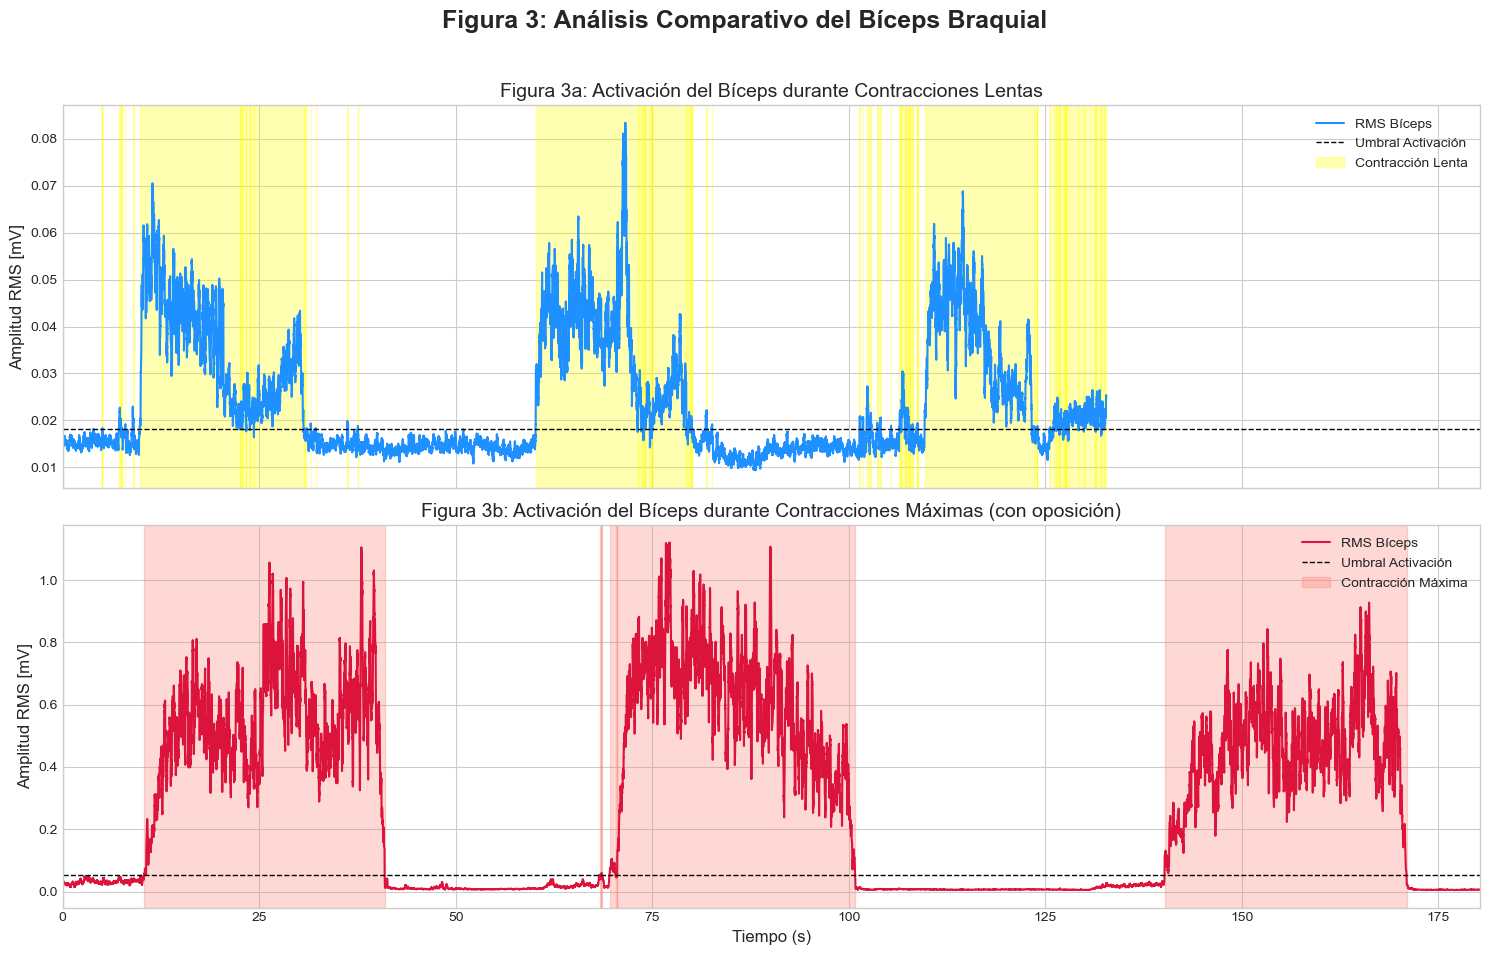

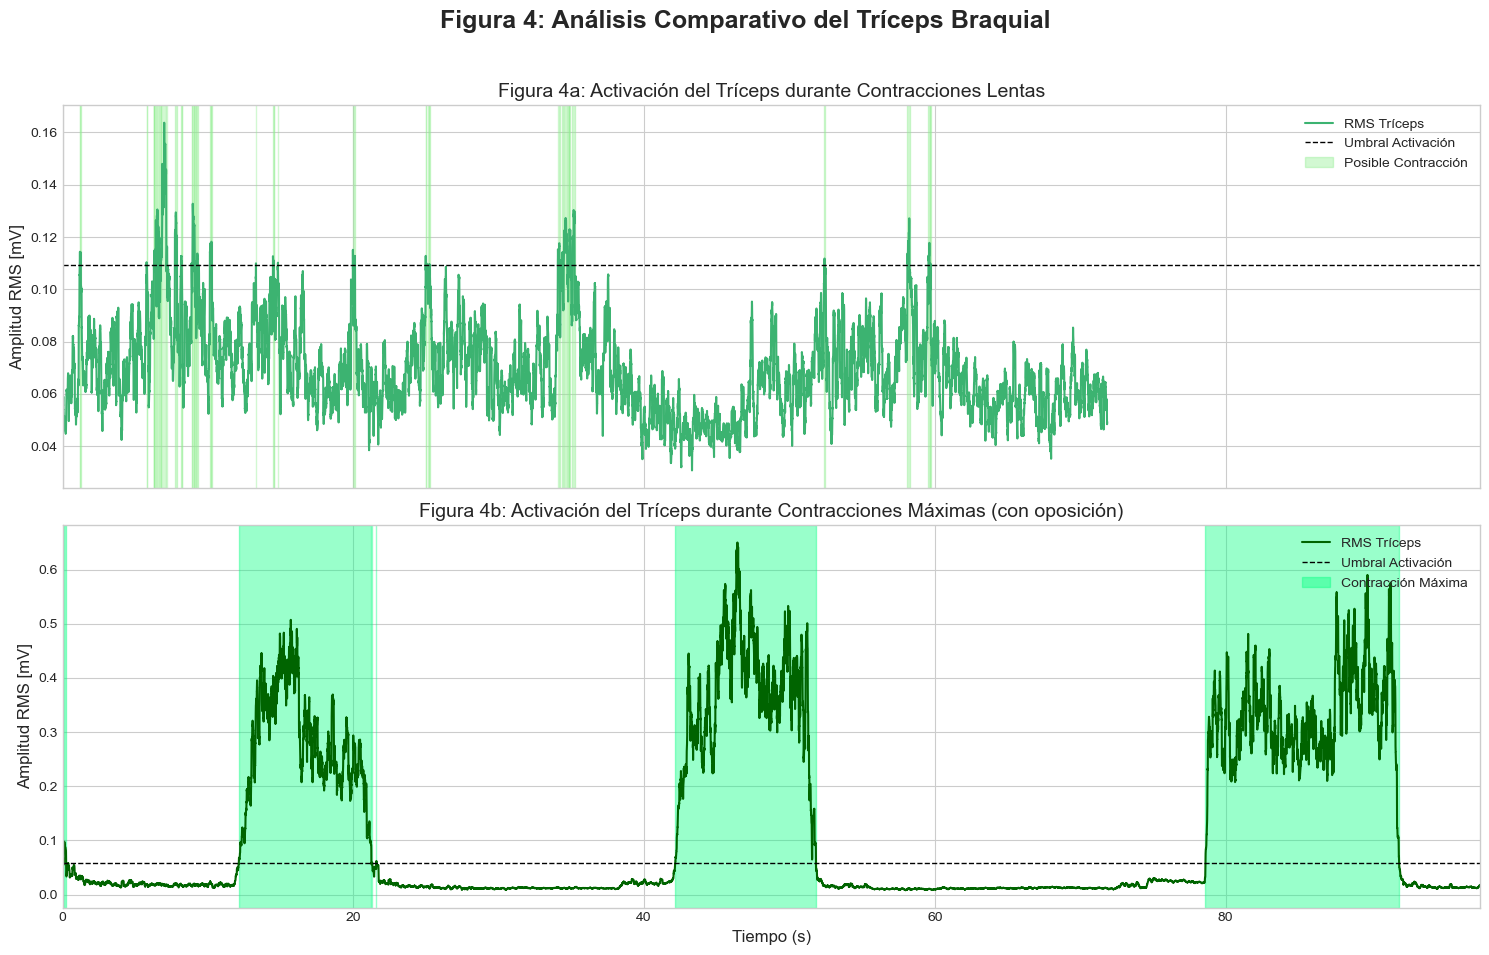

In [33]:
# Procesar y almacenar todas las señales RMS y sus eventos
senales_rms = {}
vectores_tiempo = {}
eventos_detectados = {}
umbrales = {}

print("Procesando todas las señales para el análisis en el dominio del tiempo...")
for nombre, ruta in archivos_a_analizar.items():
    adc_crudo = cargar_senal_adc(ruta)
    if adc_crudo is not None:
        emg_mv = adc_to_mv(adc_crudo, n_bits, vcc, g_emg)
        emg_filtrada = filtrar_emg(emg_mv, fs)
        emg_rms = calcular_rms(np.abs(emg_filtrada), fs)
        
        senales_rms[nombre] = emg_rms
        vectores_tiempo[nombre] = np.arange(len(emg_rms)) / fs
        
        # Detectar eventos. Usamos 10s de reposo para bíceps y tríceps máximo, 
        # y 5s para tríceps lento que podría empezar antes.
        duracion_reposo = 10 if 'maximo' in nombre else 5
        eventos, umbral = detectar_eventos(emg_rms, fs, reposo_duracion_s=duracion_reposo)
        eventos_detectados[nombre] = eventos
        umbrales[nombre] = umbral

# GRÁFICA: BÍCEPS LENTO vs. MÁXIMO
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot Bíceps Lento
t_lento = vectores_tiempo['biceps_lento']
rms_lento = senales_rms['biceps_lento']
ax1.plot(t_lento, rms_lento, color='dodgerblue', label='RMS Bíceps')
ax1.axhline(umbrales['biceps_lento'], color='k', linestyle='--', linewidth=1, label='Umbral Activación')
for i, (start, end) in enumerate(eventos_detectados['biceps_lento']):
    label = 'Contracción Lenta' if i == 0 else None
    ax1.axvspan(start/fs, end/fs, color='yellow', alpha=0.3, label=label)
ax1.set_title('Figura 3a: Activación del Bíceps durante Contracciones Lentas', fontsize=14)
ax1.set_ylabel('Amplitud RMS [mV]', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(True)

# Plot Bíceps Máximo
t_max = vectores_tiempo['biceps_maximo']
rms_max = senales_rms['biceps_maximo']
ax2.plot(t_max, rms_max, color='crimson', label='RMS Bíceps')
ax2.axhline(umbrales['biceps_maximo'], color='k', linestyle='--', linewidth=1, label='Umbral Activación')
for i, (start, end) in enumerate(eventos_detectados['biceps_maximo']):
    label = 'Contracción Máxima' if i == 0 else None
    ax2.axvspan(start/fs, end/fs, color='salmon', alpha=0.3, label=label)
ax2.set_title('Figura 3b: Activación del Bíceps durante Contracciones Máximas (con oposición)', fontsize=14)
ax2.set_xlabel('Tiempo (s)', fontsize=12)
ax2.set_ylabel('Amplitud RMS [mV]', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True)

plt.xlim(0, max(t_lento[-1], t_max[-1]))
fig.suptitle('Figura 3: Análisis Comparativo del Bíceps Braquial', fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig('grafica_biceps_tren.png', dpi=300)
plt.show()


# GRÁFICA: TRÍCEPS LENTO vs. MÁXIMO
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot Tríceps Lento
t_lento = vectores_tiempo['triceps_lento']
rms_lento = senales_rms['triceps_lento']
ax1.plot(t_lento, rms_lento, color='mediumseagreen', label='RMS Tríceps')
ax1.axhline(umbrales['triceps_lento'], color='k', linestyle='--', linewidth=1, label='Umbral Activación')
# Nota: La detección podría fallar si la señal es muy ruidosa, como describiste.
if eventos_detectados['triceps_lento']:
    for i, (start, end) in enumerate(eventos_detectados['triceps_lento']):
        label = 'Posible Contracción' if i == 0 else None
        ax1.axvspan(start/fs, end/fs, color='lightgreen', alpha=0.4, label=label)
ax1.set_title('Figura 4a: Activación del Tríceps durante Contracciones Lentas', fontsize=14)
ax1.set_ylabel('Amplitud RMS [mV]', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(True)

# Plot Tríceps Máximo
t_max = vectores_tiempo['triceps_maximo']
rms_max = senales_rms['triceps_maximo']
ax2.plot(t_max, rms_max, color='darkgreen', label='RMS Tríceps')
ax2.axhline(umbrales['triceps_maximo'], color='k', linestyle='--', linewidth=1, label='Umbral Activación')
for i, (start, end) in enumerate(eventos_detectados['triceps_maximo']):
    label = 'Contracción Máxima' if i == 0 else None
    ax2.axvspan(start/fs, end/fs, color='springgreen', alpha=0.4, label=label)
ax2.set_title('Figura 4b: Activación del Tríceps durante Contracciones Máximas (con oposición)', fontsize=14)
ax2.set_xlabel('Tiempo (s)', fontsize=12)
ax2.set_ylabel('Amplitud RMS [mV]', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True)

plt.xlim(0, max(t_lento[-1], t_max[-1]))
fig.suptitle('Figura 4: Análisis Comparativo del Tríceps Braquial', fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.savefig('grafica_triceps_tren.png', dpi=300)
plt.show()

**Interpretación de la Figura 3:** La comparación de la actividad del bíceps es reveladora. En la Figura 3a (contracciones lentas), las ráfagas de actividad alcanzan un pico de amplitud RMS de aproximadamente **0.08 mV**. Por el contrario, en la Figura 3b (contracciones máximas), la amplitud pico es drásticamente mayor, llegando a valores en torno a **0.7 mV**. Esta diferencia de magnitud, de casi un orden de magnitud, ilustra directamente la ley del reclutamiento neuromuscular: a mayor demanda de fuerza, el sistema nervioso central incrementa tanto el número de unidades motoras activas como su frecuencia de disparo, resultando en una mayor actividad eléctrica total [9].

### 3.2 Análisis del Músculo Tríceps Braquial

Se repitió el análisis para el tríceps, comparando una prueba de contracciones lentas con una de CVM.

**Interpretación de la Figura 4:** El análisis del tríceps muestra resultados interesantes. La Figura 4b, correspondiente a la CVM, presenta un patrón claro y robusto, con picos de RMS de hasta **0.4 mV**, similar en comportamiento al bíceps bajo la misma condición. Sin embargo, la Figura 4a (contracciones lentas) muestra una señal de muy baja amplitud, donde el detector de eventos apenas logra identificar picos claros por encima del umbral. Como se mencionó en la descripción del procedimiento, esto puede deberse a múltiples factores: una posible colocación subóptima de los electrodos, un nivel de tono muscular basal relativamente alto que enmascara las contracciones de baja intensidad, o que la naturaleza del movimiento de extensión lenta no demandó un reclutamiento muscular significativamente superior al del tono. Este resultado subraya la importancia de una correcta técnica de medición para capturar de forma fiable la actividad muscular de baja intensidad.

### 3.3 Comparación de la Dinámica de Activación

Para analizar no solo la magnitud sino también la forma de la activación muscular, se segmentó y alineó la primera ráfaga de contracción de los tres ensayos principales.


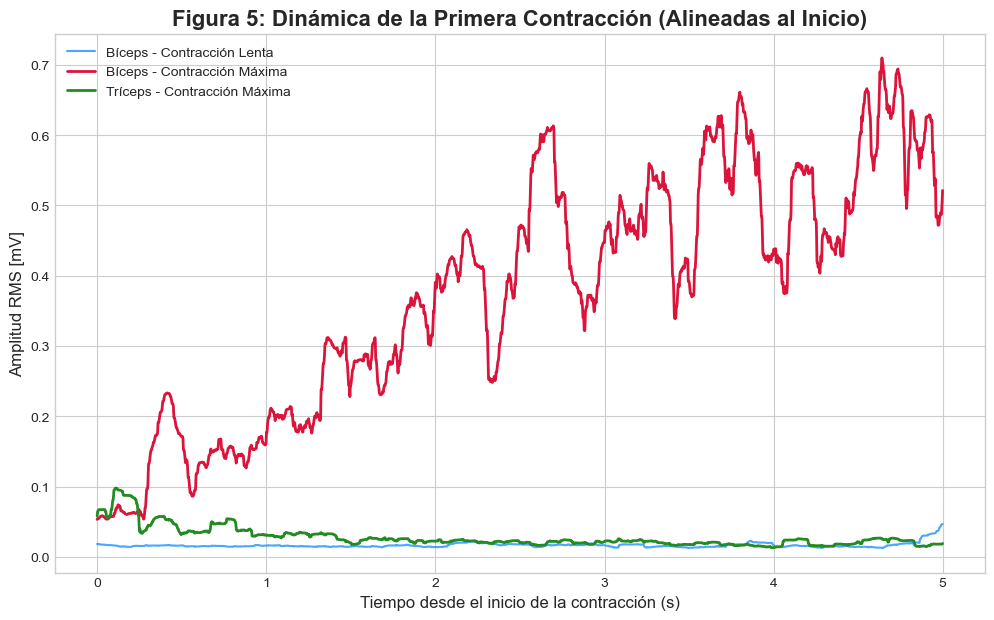

In [34]:
plt.figure(figsize=(12, 7))
duracion_plot_s = 5 # Duración en segundos a plotear después del inicio de la contracción

# --- Procesar y plotear Bíceps Lento ---
eventos_bl = eventos_detectados['biceps_lento']
if eventos_bl:
    start, end = eventos_bl[0]
    # Asegurarse de no exceder la longitud del array
    end_plot = min(start + int(duracion_plot_s * fs), len(senales_rms['biceps_lento']))
    segmento = senales_rms['biceps_lento'][start : end_plot]
    t_segment = np.arange(len(segmento)) / fs
    plt.plot(t_segment, segmento, label='Bíceps - Contracción Lenta', color='dodgerblue', alpha=0.8)

# --- Procesar y plotear Bíceps Máximo ---
eventos_bm = eventos_detectados['biceps_maximo']
if eventos_bm:
    start, end = eventos_bm[0]
    end_plot = min(start + int(duracion_plot_s * fs), len(senales_rms['biceps_maximo']))
    segmento = senales_rms['biceps_maximo'][start : end_plot]
    t_segment = np.arange(len(segmento)) / fs
    plt.plot(t_segment, segmento, label='Bíceps - Contracción Máxima', color='crimson', linewidth=2)

# --- Procesar y plotear Tríceps Máximo ---
eventos_tm = eventos_detectados['triceps_maximo']
if eventos_tm:
    start, end = eventos_tm[0]
    end_plot = min(start + int(duracion_plot_s * fs), len(senales_rms['triceps_maximo']))
    segmento = senales_rms['triceps_maximo'][start : end_plot]
    t_segment = np.arange(len(segmento)) / fs
    plt.plot(t_segment, segmento, label='Tríceps - Contracción Máxima', color='forestgreen', linewidth=2)

plt.title('Figura 5: Dinámica de la Primera Contracción (Alineadas al Inicio)', fontsize=16, weight='bold')
plt.xlabel('Tiempo desde el inicio de la contracción (s)', fontsize=12)
plt.ylabel('Amplitud RMS [mV]', fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig('grafica_segmentos_comparacion.png', dpi=300)
plt.show()

**Interpretación de la Figura 5:** Esta vista detallada permite comparar la dinámica de la activación. Se observa que las contracciones máximas (la roja para el bíceps y la verde para el tríceps) no solo alcanzan una mayor amplitud, sino que también presentan una pendiente de subida mucho más pronunciada en comparación con la contracción lenta (azul). Esto sugiere un reclutamiento de unidades motoras más rápido y sincrónico cuando la demanda de fuerza es alta e inmediata. Por el contrario, la contracción lenta del bíceps muestra una subida más gradual y una amplitud menor y más fluctuante, lo que es coherente con un control motor más fino y una activación muscular menos intensa, donde las unidades motoras son reclutadas de manera más progresiva [9].

## 4. Análisis en el Dominio de la Frecuencia
---

Además de la amplitud, la distribución de frecuencias de la señal sEMG contiene información valiosa. El análisis espectral permite verificar que la señal registrada se encuentra dentro del ancho de banda fisiológico esperado para la actividad muscular. Para ello, se calcula el **Espectro de Densidad de Potencia (PSD)**, que muestra cómo se distribuye la energía de la señal en las diferentes frecuencias [10].

Para asegurar un análisis robusto, se seleccionó manualmente un segmento estable de 5 segundos dentro de la primera contracción voluntaria máxima (CVM) registrada para cada músculo. Se utilizó la **señal filtrada** (previa a la rectificación y RMS) para este análisis.

Realizando análisis de frecuencia en segmentos seleccionados manualmente...


C:\Users\Alvaro\AppData\Local\Temp\ipykernel_4024\2582466692.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data_df = pd.read_csv(ruta_archivo, comment='#', delim_whitespace=True, header=None)
C:\Users\Alvaro\AppData\Local\Temp\ipykernel_4024\2582466692.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data_df = pd.read_csv(ruta_archivo, comment='#', delim_whitespace=True, header=None)


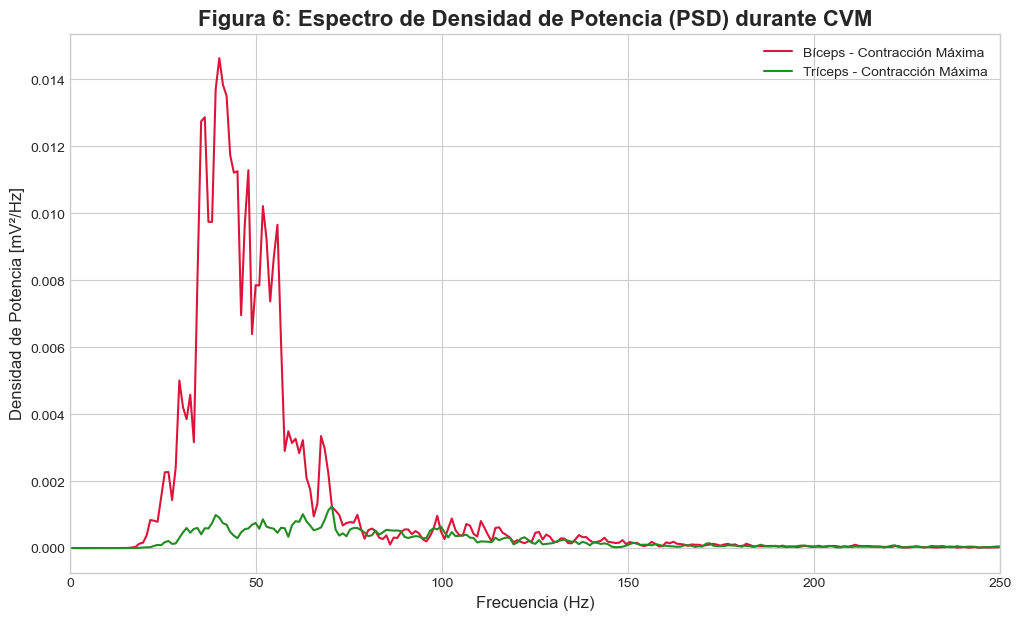

In [35]:
# Diccionario para guardar los resultados del PSD
psd_resultados = {}
# Duración del segmento a analizar en segundos
duracion_segmento_s = 5.0

print("Realizando análisis de frecuencia en segmentos seleccionados manualmente...")

# --- Análisis para el Bíceps ---
nombre_biceps = 'biceps_maximo'
adc_crudo_b = cargar_senal_adc(archivos_a_analizar[nombre_biceps])
if adc_crudo_b is not None:
    emg_mv_b = adc_to_mv(adc_crudo_b)
    emg_filtrada_b = filtrar_emg(emg_mv_b, fs)
    
    # Selección manual del segmento (primera contracción: 10-40s)
    # Tomaremos un segmento estable en el medio, por ejemplo de 15s a 20s
    start_s = 15.0
    end_s = start_s + duracion_segmento_s
    segmento_b = emg_filtrada_b[int(start_s * fs) : int(end_s * fs)]
    
    # Calcular PSD
    frecuencias_b, psd_b = welch(segmento_b, fs, nperseg=1024)
    psd_resultados[nombre_biceps] = (frecuencias_b, psd_b)

# --- Análisis para el Tríceps ---
nombre_triceps = 'triceps_maximo'
adc_crudo_t = cargar_senal_adc(archivos_a_analizar[nombre_triceps])
if adc_crudo_t is not None:
    emg_mv_t = adc_to_mv(adc_crudo_t)
    emg_filtrada_t = filtrar_emg(emg_mv_t, fs)
    
    # Selección manual del segmento (primera contracción: ~15-25s)
    # Tomaremos un segmento estable, por ejemplo de 17s a 22s
    start_s = 17.0
    end_s = start_s + duracion_segmento_s
    segmento_t = emg_filtrada_t[int(start_s * fs) : int(end_s * fs)]
    
    # Calcular PSD
    frecuencias_t, psd_t = welch(segmento_t, fs, nperseg=1024)
    psd_resultados[nombre_triceps] = (frecuencias_t, psd_t)

# --- Graficar los resultados del PSD ---
plt.figure(figsize=(12, 7))

if 'biceps_maximo' in psd_resultados:
    freqs, psd = psd_resultados['biceps_maximo']
    plt.plot(freqs, psd, label='Bíceps - Contracción Máxima', color='crimson')

if 'triceps_maximo' in psd_resultados:
    freqs, psd = psd_resultados['triceps_maximo']
    plt.plot(freqs, psd, label='Tríceps - Contracción Máxima', color='forestgreen')

plt.title('Figura 6: Espectro de Densidad de Potencia (PSD) durante CVM', fontsize=16, weight='bold')
plt.xlabel('Frecuencia (Hz)', fontsize=12)
plt.ylabel('Densidad de Potencia [mV²/Hz]', fontsize=12)
plt.xlim(0, 250)
plt.legend()
plt.grid(True)
plt.savefig('grafica_psd.png', dpi=300)
plt.show()

**Interpretación de la Figura 6:** El análisis espectral confirma las características esperadas de una señal sEMG. Para ambos músculos durante la contracción máxima, la mayor parte de la energía se concentra en la banda de frecuencia entre aproximadamente 40 Hz y 150 Hz.

El **bíceps** muestra un pico de potencia dominante y claro alrededor de los **45 Hz**. El **tríceps**, por su parte, también presenta su mayor actividad en este rango, aunque con una distribución de potencia y un pico que parecen estar a una frecuencia ligeramente superior, lo cual es normal debido a las diferencias anatómicas y de reclutamiento de fibras entre ambos músculos.

Esta distribución es consistente con la literatura y valida la calidad de la adquisición. Demuestra que la señal registrada corresponde a la suma de potenciales de acción de las unidades motoras y no a ruido aleatorio. La disminución de la potencia por encima de los 150-200 Hz también es típica, debido a los efectos de filtrado de los propios tejidos biológicos entre las fibras musculares y el electrodo en la piel [10].

---
## **Referencias**

[1] Istanbul Onkoloji, “What is EMG? When is it done?”, Healthy lifestyle (blog), Jul. 28, 2017. [En línea]. Disponible: İstanbul Onkoloji. [Consultado: 8-Sep-2025].

[2] M. A. Cavalcanti. García y T. M. M. Vieira, “Surface electromyography: Why, when and how to use it”, Revista Andaluza de Medicina del Deporte, vol. 4, no. 1, pp. 17–28, 2011.

[3] M. Proença and K. Mrotzeck, BITalino (r)evolution Home Guide #1: Electromyography (EMG) – Exploring Muscular Signals. Lisbon, Portugal: PLUX – Wireless Biosignals S.A., Feb. 2021 .

[4] Electromyography (EMG) Sensor User Manual [Internet]. Available from: https://support.pluxbiosignals.com/wp-content/uploads/2021/11/electromyography-emg-user-manual.pdf 

[5] (PDF) The abc of emg [Internet]. ResearchGate. Available from: https://www.researchgate.net/publication/270895853_The_abc_of_emg

[6] Staudenmann D, Roeleveld K, Stegeman DF, van Dieën JH. Methodological aspects of SEMG recordings for force estimation – A tutorial and review. Journal of Electromyography and Kinesiology. 2010 Jun;20(3):375–87.

[7] Clancy EA, Morin EL, Merletti R. Sampling, noise-reduction and amplitude estimation issues in surface electromyography. Journal of Electromyography and Kinesiology. 2002 Feb;12(1):1–16.

[8] Morey-Klapsing G, Arampatzis A, Brüggemann GP. Choosing EMG parameters: comparison of different onset determination algorithms and EMG integrals in a joint stability study. Clinical Biomechanics. 2004 Feb;19(2):196–201.

[9] De Luca C. SURFACE ELECTROMYOGRAPHY: DETECTION AND RECORDING [Internet]. 2002. Available from: https://www.delsys.com/downloads/TUTORIAL/semg-detection-and-recording.pdf 

[10] Phinyomark, A., Nuidod, A., Phukpattaranont, P. and Limsakul, C. (2012) Feature Extraction and Reduction of Wavelet Transform Coefficients for EMG Pattern Classification. Electronics and Electrical Engineering, 122, 1392-1215. - References - Scientific Research Publishing [Internet]. Scirp.org. 2018 [cited 2025 Sep 9]. Available from: https://www.scirp.org/reference/referencespapers?referenceid=2290336

In [42]:
# Adicionalmente, si queremos exportar el notebook para una visualización más facil en pdf podemos usar
# !pip install "nbconvert[webpdf]"
# !playwright install chromium
#!jupyter nbconvert --to webpdf procesamiento_senales.ipynb
# o a .md
# !jupyter nbconvert --to markdown procesamiento_senales.ipynb

---